Top ROIs por frecuencia en top-20:
ROI_Name
Amygdala_L              5.0
Heschl_R                5.0
Vermis_6                5.0
Rolandic_Oper_R         5.0
Putamen_R               5.0
Lingual_R               5.0
Vermis_7                5.0
Cerebelum_9_R           5.0
Occipital_Mid_R         4.0
Cuneus_R                4.0
Parietal_Sup_R          4.0
OFClat_R                4.0
Temporal_Inf_R          3.0
Occipital_Inf_L         3.0
Cingulate_Mid_L         3.0
Pallidum_R              3.0
Paracentral_Lobule_R    2.0
Temporal_Pole_Sup_L     2.0
Cerebelum_4_5_R         2.0
Rectus_R                2.0
Postcentral_R           2.0
Fusiform_R              2.0
Cerebelum_Crus1_R       2.0
Cingulate_Mid_R         2.0
Occipital_Inf_R         2.0
Frontal_Med_Orb_R       2.0
Parietal_Inf_R          1.0
Frontal_Inf_Orb_2_R     1.0
Olfactory_R             1.0
Occipital_Sup_R         1.0
dtype: float64
                      mean_saliency  std_saliency
ROI_Name                                         
H

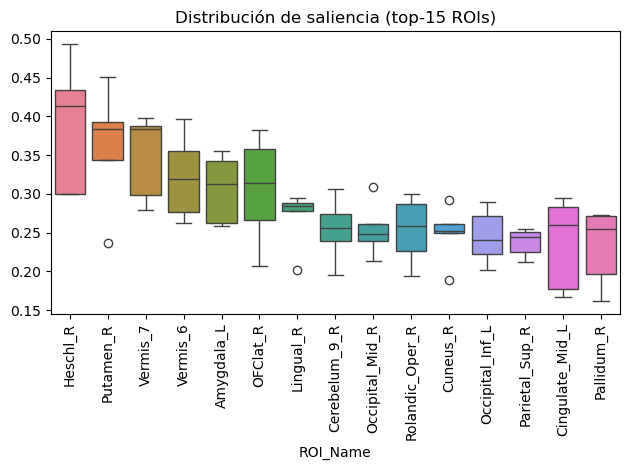

In [1]:
import pandas as pd, glob, numpy as np, matplotlib.pyplot as plt, seaborn as sns, pathlib

root = pathlib.Path("./resultados_12_inter")
top_k = 20

# 1) Leer rankings
ranks = {}
for csv in root.glob("fold_*/roi_saliency_ranking.csv"):
    df = pd.read_csv(csv)
    ranks[csv.parent.name] = df

# 2) Tabla de frecuencia
roi_counts = pd.Series(dtype=int)
for fold, df in ranks.items():
    roi_counts = roi_counts.add(df.head(top_k)["ROI_Name"].value_counts(), fill_value=0)
roi_counts = roi_counts.sort_values(ascending=False)

print("Top ROIs por frecuencia en top-20:")
print(roi_counts.head(30))

# 3) Saliencia media ± std
all_scores = pd.concat(
    [df.set_index("ROI_Name")["Saliency_Score"].rename(fold) for fold, df in ranks.items()],
    axis=1
)
summary = pd.DataFrame({
    "mean_saliency": all_scores.mean(axis=1),
    "std_saliency":  all_scores.std(axis=1)
}).sort_values("mean_saliency", ascending=False)
print(summary.head(30))

# 4) Boxplot varianza
top_rois = summary.head(15).index
sns.boxplot(data=all_scores.loc[top_rois].T)
plt.xticks(rotation=90); plt.title("Distribución de saliencia (top-15 ROIs)")
plt.tight_layout(); plt.show()




--- RANKING GLOBAL Y ROBUSTO DE ROIs (PROMEDIO DE 5 FOLDS) ---
Tabla de resultados guardada en: global_robust_roi_ranking_final.csv
    ROI_Name      Yeo17_Network  Mean_Saliency  Std_Saliency
0        O1L  Visual_Peripheral       0.408504      0.054089
1        O1R  Visual_Peripheral       0.368306      0.059232
2        O2L  Visual_Peripheral       0.348388      0.049439
3        O2R  Visual_Peripheral       0.330491      0.045813
4        O3L  Visual_Peripheral       0.313121      0.039900
5        O3R  Visual_Peripheral       0.291913      0.035450
6      FUSIL  Visual_Peripheral       0.280098      0.031549
7      FUSIR  Visual_Peripheral       0.268000      0.028626
8   CERCRU1L  Visual_Peripheral       0.261703      0.028483
9   CERCRU1R  Visual_Peripheral       0.254349      0.026001
10     CER6L  Visual_Peripheral       0.252273      0.026438
11     CER6R  Visual_Peripheral       0.248956      0.028135
12      VER6  Visual_Peripheral       0.245534      0.026304
13       V1L 

/tmp/ipykernel_3340566/4049793249.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Gráfico final con barras de error guardado en: final_roi_ranking_with_errorbars.png


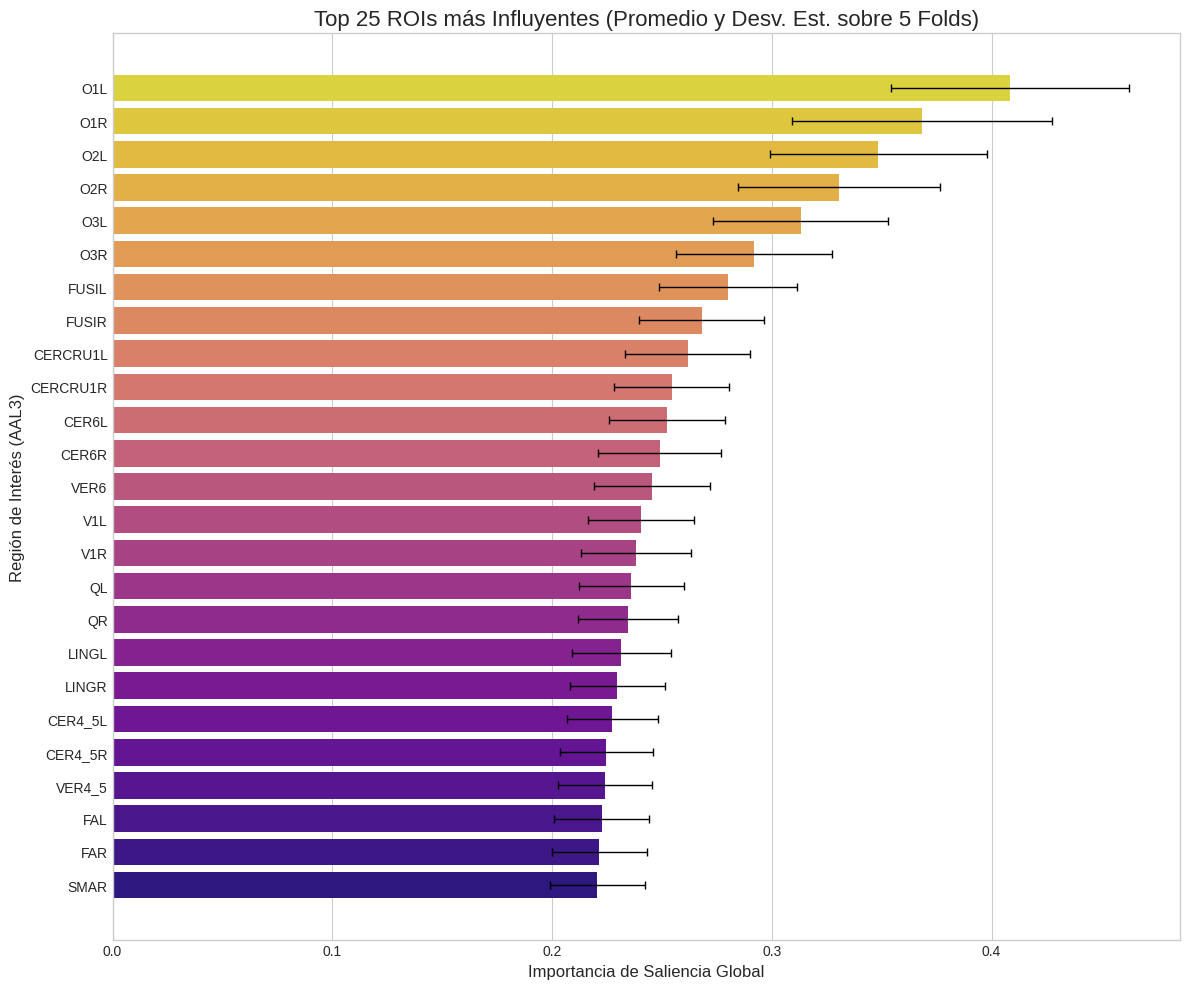

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def create_final_analysis(saliency_csv_files: list, roi_map_path: str, output_dir: Path):
    """
    Agrega los rankings de saliencia de todos los folds, los une con la
    información de la red y genera el análisis y visualizaciones finales.
    """
    if not saliency_csv_files:
        print("Error: No se proporcionaron ficheros CSV de saliencia.")
        return

    # Cargar todos los ficheros CSV de saliencia
    try:
        all_fold_dfs = [pd.read_csv(file) for file in saliency_csv_files]
    except FileNotFoundError as e:
        print(f"Error al cargar uno de los ficheros CSV: {e}")
        return

    # Extraer solo la columna de scores de cada fold para asegurar el orden
    all_scores = [df['Saliency_Score'].values for df in all_fold_dfs]
    
    # Apilar y calcular la media y desviación estándar a través de los folds
    global_roi_saliency_mean = np.mean(all_scores, axis=0)
    global_roi_saliency_std = np.std(all_scores, axis=0)

    # Cargar el dataframe de mapeo, que es nuestra base con los nombres y redes correctos
    final_ranking_df = pd.read_csv(roi_map_path)
    
    # Añadir directamente las columnas de saliencia calculadas.
    # Esto funciona porque ambos (el mapeo y los scores) tienen 131 elementos en el mismo orden.
    final_ranking_df['Mean_Saliency'] = global_roi_saliency_mean
    final_ranking_df['Std_Saliency'] = global_roi_saliency_std
    
    # Renombrar la columna de nombres para claridad en los gráficos
    final_ranking_df.rename(columns={'AAL3_Name': 'ROI_Name'}, inplace=True)

    # Ordenar por la saliencia media para obtener el ranking final
    final_ranking_df = final_ranking_df.sort_values(by='Mean_Saliency', ascending=False).reset_index(drop=True)
    
    # Guardar la tabla final y completa
    final_csv_path = output_dir / "global_robust_roi_ranking_final.csv"
    final_ranking_df[['ROI_Name', 'Yeo17_Network', 'Mean_Saliency', 'Std_Saliency']].to_csv(final_csv_path, index=False)
    
    print(f"\n--- RANKING GLOBAL Y ROBUSTO DE ROIs (PROMEDIO DE {len(saliency_csv_files)} FOLDS) ---")
    print(f"Tabla de resultados guardada en: {final_csv_path}")
    print(final_ranking_df[['ROI_Name', 'Yeo17_Network', 'Mean_Saliency', 'Std_Saliency']].head(25))

    # --- Visualización Final con Barras de Error ---
    top_25_rois = final_ranking_df.head(25)
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 10))
    
    sns.barplot(
        x='Mean_Saliency',
        y='ROI_Name',
        data=top_25_rois,
        palette='plasma_r',
        ax=ax
    )
    
    ax.errorbar(
        x=top_25_rois['Mean_Saliency'],
        y=np.arange(len(top_25_rois)),
        xerr=top_25_rois['Std_Saliency'],
        fmt='none',
        c='black',
        capsize=3,
        linewidth=1
    )

    ax.set_title('Top 25 ROIs más Influyentes (Promedio y Desv. Est. sobre 5 Folds)', fontsize=16)
    ax.set_xlabel('Importancia de Saliencia Global', fontsize=12)
    ax.set_ylabel('Región de Interés (AAL3)', fontsize=12)
    plt.tight_layout()
    
    final_plot_path = output_dir / "final_roi_ranking_with_errorbars.png"
    plt.savefig(final_plot_path, dpi=300)
    print(f"\nGráfico final con barras de error guardado en: {final_plot_path}")
    plt.show()

# --- Ejecución del Script ---
saliency_files = [
    '/home/diego/Escritorio/limpio/resultados_12_inter/fold_1/roi_saliency_ranking.csv',
    '/home/diego/Escritorio/limpio/resultados_12_inter/fold_2/roi_saliency_ranking.csv',
    '/home/diego/Escritorio/limpio/resultados_12_inter/fold_3/roi_saliency_ranking.csv',
    '/home/diego/Escritorio/limpio/resultados_12_inter/fold_4/roi_saliency_ranking.csv',
    '/home/diego/Escritorio/limpio/resultados_12_inter/fold_5/roi_saliency_ranking.csv'
]
roi_map_file = 'aal3_131_to_yeo17_mapping.csv'
output_directory = Path('./')

create_final_analysis(saliency_files, roi_map_file, output_directory)